In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/multi-lingual-sentiment-analysis/multi-lingual-sentiment-analysis/sample_submission.csv
/kaggle/input/multi-lingual-sentiment-analysis/multi-lingual-sentiment-analysis/train.csv
/kaggle/input/multi-lingual-sentiment-analysis/multi-lingual-sentiment-analysis/test.csv
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model.safetensors.index.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00003-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/LICENSE
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00001-of-00004.safetensors
/kaggle/input/llama-3.1/transformers/8b-instruct/2/README.md
/kaggle/input/llama-3.1/transformers/8b-instruct/2/USE_POLICY.md
/kaggle/input/llama-3.1/transformers/8b-instruct/2/tokenizer.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/tokenizer_config.json
/kaggle/input/llama-3.1/transformers/8b-instruct/2/model-00004-of-00004.safetensors


In [2]:
%%capture
!pip install bitsandbytes
!pip install unsloth
!pip install accelerate
!pip install peft
!pip install torch==2.1.2 --force-reinstall
!pip install --upgrade transformers
!pip install --upgrade unsloth

import torch._dynamo


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import re
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import os

# Set the style for better visualizations
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Load the datasets
train_path = "/kaggle/input/multi-lingual-sentiment-analysis/multi-lingual-sentiment-analysis/train.csv"
test_path = "/kaggle/input/multi-lingual-sentiment-analysis/multi-lingual-sentiment-analysis/test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

#  Basic Dataset Information
print("Train Dataset Shape:", train_df.shape)
print("Test Dataset Shape:", test_df.shape)
print("\nTrain Dataset Columns:", train_df.columns.tolist())
print("Test Dataset Columns:", test_df.columns.tolist())




Train Dataset Shape: (1000, 4)
Test Dataset Shape: (100, 3)

Train Dataset Columns: ['ID', 'sentence', 'label', 'language']
Test Dataset Columns: ['ID', 'sentence', 'language']


In [4]:
#  Check for missing values
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())
print("\nMissing Values in Test Dataset:")
print(test_df.isnull().sum())

#  Dataset Summary
print("\nTrain Dataset Summary:")
print(train_df.describe(include='all'))



Missing Values in Train Dataset:
ID          0
sentence    0
label       0
language    0
dtype: int64

Missing Values in Test Dataset:
ID          0
sentence    0
language    0
dtype: int64

Train Dataset Summary:
                 ID                                           sentence  \
count   1000.000000                                               1000   
unique          NaN                                               1000   
top             NaN  మీరు ఒక ట్రైలర్ చూస్తే, అది ఒక అద్భుత కథలా కని...   
freq            NaN                                                  1   
mean     500.500000                                                NaN   
std      288.819436                                                NaN   
min        1.000000                                                NaN   
25%      250.750000                                                NaN   
50%      500.500000                                                NaN   
75%      750.250000                          

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [5]:

#  Language Distribution
language_counts = train_df['language'].value_counts()
print("\nLanguage Distribution in Train Set:")
print(language_counts)

language_map = {
    "as": "Assamese",
    "bd": "Bodo",
    "bn": "Bengali",
    "gu": "Gujarati",
    "hi": "Hindi",
    "kn": "Kannada",
    "ml": "Malayalam",
    "mr": "Marathi",
    "or": "Odia",
    "pa": "Punjabi",
    "ta": "Tamil",
    "te": "Telugu",
    "ur": "Urdu"
}


train_df['language_full'] = train_df['language'].map(language_map)
test_df['language_full'] = test_df['language'].map(language_map)



Language Distribution in Train Set:
language
bn    77
gu    77
ta    77
pa    77
bd    77
as    77
te    77
or    77
hi    77
ur    77
mr    77
kn    77
ml    76
Name: count, dtype: int64


In [6]:
#  Sentiment Distribution
print("\nSentiment Distribution in Train Set:")
sentiment_counts = train_df['label'].value_counts()
print(sentiment_counts)















Sentiment Distribution in Train Set:
label
Positive    507
Negative    493
Name: count, dtype: int64


In [7]:
#  Sentiment Distribution by Language
sentiment_by_language = pd.crosstab(train_df['language_full'], train_df['label'])
print("\nSentiment Distribution by Language:")
print(sentiment_by_language)














Sentiment Distribution by Language:
label          Negative  Positive
language_full                    
Assamese             38        39
Bengali              38        39
Bodo                 38        39
Gujarati             38        39
Hindi                38        39
Kannada              38        39
Malayalam            37        39
Marathi              38        39
Odia                 38        39
Punjabi              38        39
Tamil                38        39
Telugu               38        39
Urdu                 38        39


In [8]:
#  Text Length Analysis
train_df['text_length'] = train_df['sentence'].apply(len)
test_df['text_length'] = test_df['sentence'].apply(len)

print("\nText Length Statistics (Train Set):")
print(train_df['text_length'].describe())

print("\nText Length Statistics by Language (Train Set):")
print(train_df.groupby('language_full')['text_length'].describe())



Text Length Statistics (Train Set):
count    1000.00000
mean      136.70400
std        73.65995
min        14.00000
25%        86.00000
50%       126.00000
75%       168.25000
max       651.00000
Name: text_length, dtype: float64

Text Length Statistics by Language (Train Set):
               count        mean         std   min    25%    50%     75%  \
language_full                                                              
Assamese        77.0  137.246753   63.042625  19.0  100.0  131.0  164.00   
Bengali         77.0  128.038961   60.149910  18.0   87.0  126.0  160.00   
Bodo            77.0  140.441558   66.645664  17.0  102.0  136.0  173.00   
Gujarati        77.0  120.597403   56.261434  25.0   85.0  115.0  147.00   
Hindi           77.0  138.012987   79.862463  25.0   87.0  119.0  175.00   
Kannada         77.0  145.272727   74.307086  21.0   88.0  138.0  194.00   
Malayalam       76.0  167.552632  108.952270  33.0  103.5  141.5  203.25   
Marathi         77.0  142.688312   7

In [9]:
#  Word Count Analysis
train_df['word_count'] = train_df['sentence'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['sentence'].apply(lambda x: len(str(x).split()))

print("\nWord Count Statistics (Train Set):")
print(train_df['word_count'].describe())

print("\nWord Count Statistics by Language (Train Set):")
print(train_df.groupby('language_full')['word_count'].describe())

#  Word Count vs Sentiment
print("\nWord Count vs Sentiment (Train Set):")
print(train_df.groupby('label')['word_count'].describe())


Word Count Statistics (Train Set):
count    1000.000000
mean       21.244000
std        11.899751
min         2.000000
25%        13.000000
50%        19.000000
75%        27.000000
max        94.000000
Name: word_count, dtype: float64

Word Count Statistics by Language (Train Set):
               count       mean        std  min   25%   50%    75%   max
language_full                                                           
Assamese        77.0  21.909091  10.243331  4.0  16.0  21.0  27.00  61.0
Bengali         77.0  20.675325   9.516525  4.0  14.0  20.0  25.00  53.0
Bodo            77.0  20.519481   9.936125  3.0  16.0  19.0  25.00  48.0
Gujarati        77.0  21.584416  10.267925  6.0  14.0  21.0  26.00  55.0
Hindi           77.0  27.402597  15.482809  5.0  17.0  24.0  35.00  94.0
Kannada         77.0  17.090909   8.511883  2.0  11.0  16.0  22.00  41.0
Malayalam       76.0  17.276316  10.674079  4.0  10.0  15.5  21.25  62.0
Marathi         77.0  21.324675  11.586564  3.0  14.0  19.

In [10]:
#  Character Distribution
def count_unique_chars(text):
    return len(set(text))

train_df['unique_chars'] = train_df['sentence'].apply(count_unique_chars)
test_df['unique_chars'] = test_df['sentence'].apply(count_unique_chars)

print("\nUnique Character Count Statistics (Train Set):")
print(train_df['unique_chars'].describe())

print("\nUnique Character Count by Language (Train Set):")
print(train_df.groupby('language_full')['unique_chars'].describe())


Unique Character Count Statistics (Train Set):
count    1000.000000
mean       33.235000
std         7.353628
min        12.000000
25%        28.000000
50%        34.000000
75%        38.000000
max        58.000000
Name: unique_chars, dtype: float64

Unique Character Count by Language (Train Set):
               count       mean       std   min   25%   50%   75%   max
language_full                                                          
Assamese        77.0  35.922078  7.351631  12.0  33.0  36.0  39.0  51.0
Bengali         77.0  33.376623  7.128591  12.0  30.0  34.0  38.0  46.0
Bodo            77.0  29.155844  5.586791  12.0  27.0  29.0  33.0  44.0
Gujarati        77.0  33.766234  6.043474  18.0  30.0  34.0  37.0  46.0
Hindi           77.0  35.077922  7.390902  17.0  30.0  36.0  40.0  53.0
Kannada         77.0  33.441558  6.972679  14.0  30.0  34.0  38.0  48.0
Malayalam       76.0  37.236842  8.483503  18.0  32.0  37.0  43.0  58.0
Marathi         77.0  34.844156  7.739279  12.0  31.

In [11]:
#  Sentiment vs Text Length
print("\nText Length by Sentiment (Train Set):")
print(train_df.groupby('label')['text_length'].describe())

#  Most Common Words by Language (for a few languages)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')

def get_top_words(df, language_code, top_n=10):
    subset = df[df['language'] == language_code]
    all_words = ' '.join(subset['sentence']).lower()
    all_words = re.sub(r'[^\w\s]', '', all_words)
    word_counts = Counter(all_words.split())
    return word_counts.most_common(top_n)
# Get top words for Hindi and Bengali as examples
hindi_top_words = get_top_words(train_df, 'hi')
bengali_top_words = get_top_words(train_df, 'bn')

print("\nTop 10 words in Hindi text:")
print(hindi_top_words)

print("\nTop 10 words in Bengali text:")
print(bengali_top_words)



Text Length by Sentiment (Train Set):
          count        mean        std   min   25%    50%    75%    max
label                                                                  
Negative  493.0  124.947262  62.874288  14.0  78.0  118.0  159.0  378.0
Positive  507.0  148.136095  81.257357  19.0  93.5  134.0  184.5  651.0

Top 10 words in Hindi text:
[('ह', 200), ('क', 165), ('और', 82), ('म', 46), ('यह', 44), ('नह', 35), ('एक', 31), ('लए', 28), ('स', 24), ('अचछ', 24)]

Top 10 words in Bengali text:
[('এব', 61), ('কর', 44), ('এট', 36), ('একট', 30), ('জনয', 25), ('এই', 21), ('য', 20), ('ভল', 16), ('তর', 12), ('পর', 12)]


In [12]:
#  Data Consistency Checks
print("\nChecking for duplicate IDs in Train set:")
print(train_df['ID'].duplicated().sum(), "duplicates found")

print("\nChecking for duplicate IDs in Test set:")
print(test_df['ID'].duplicated().sum(), "duplicates found")

print("\nChecking ID ranges:")
print("Train ID range:", train_df['ID'].min(), "to", train_df['ID'].max())
print("Test ID range:", test_df['ID'].min(), "to", test_df['ID'].max())


Checking for duplicate IDs in Train set:
0 duplicates found

Checking for duplicate IDs in Test set:
0 duplicates found

Checking ID ranges:
Train ID range: 1 to 1000
Test ID range: 1 to 100


In [13]:
#  Test Set Analysis - Compare with Train
print("\nLanguage Distribution Comparison:")
test_lang_counts = test_df['language'].value_counts()
train_lang_pct = (language_counts / language_counts.sum() * 100).round(2)
test_lang_pct = (test_lang_counts / test_lang_counts.sum() * 100).round(2)

lang_comparison = pd.DataFrame({
    'Train Count': language_counts,
    'Train %': train_lang_pct,
    'Test Count': test_lang_counts,
    'Test %': test_lang_pct
})
print(lang_comparison)



Language Distribution Comparison:
          Train Count  Train %  Test Count  Test %
language                                          
as                 77      7.7           8     8.0
bd                 77      7.7           8     8.0
bn                 77      7.7           7     7.0
gu                 77      7.7           8     8.0
hi                 77      7.7           8     8.0
kn                 77      7.7           7     7.0
ml                 76      7.6           8     8.0
mr                 77      7.7           7     7.0
or                 77      7.7           8     8.0
pa                 77      7.7           8     8.0
ta                 77      7.7           8     8.0
te                 77      7.7           8     8.0
ur                 77      7.7           7     7.0


In [14]:
#  Class Imbalance Check
class_imbalance = sentiment_counts / sentiment_counts.sum()
print("\nClass Imbalance (Sentiment Distribution):")
print(class_imbalance)


Class Imbalance (Sentiment Distribution):
label
Positive    0.507
Negative    0.493
Name: count, dtype: float64


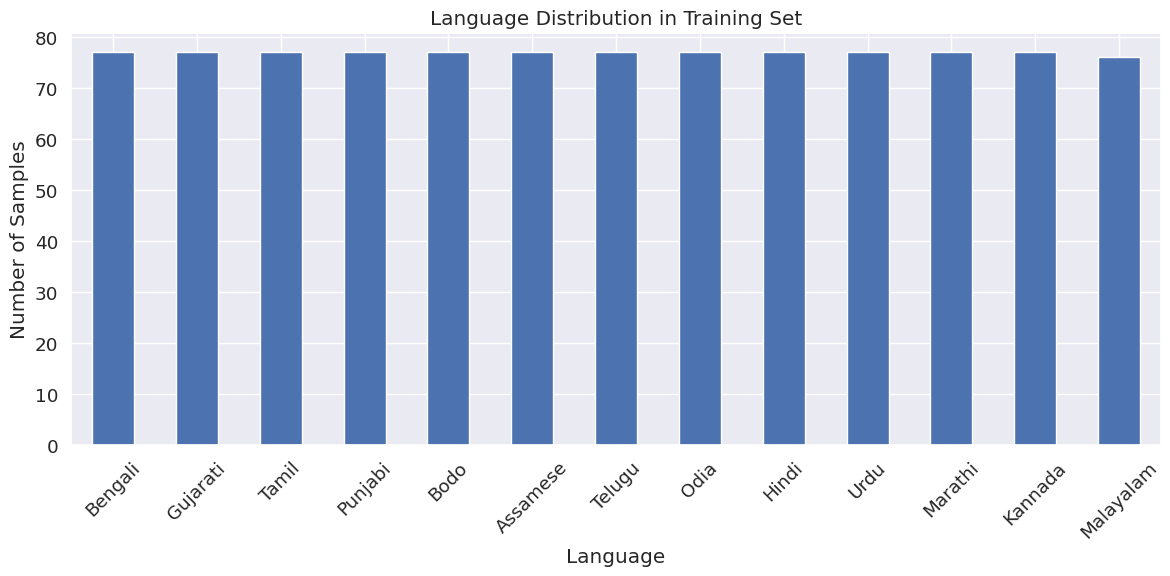

In [15]:
#  Language Distribution in Train Set
plt.figure(figsize=(12, 6))
train_df['language_full'].value_counts().plot(kind='bar')
plt.title('Language Distribution in Training Set')
plt.xlabel('Language')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('language_distribution_train.png')

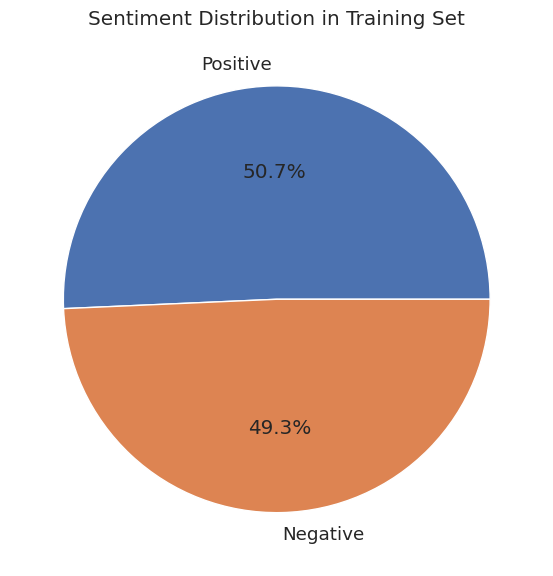

In [16]:
#  Sentiment Distribution
plt.figure(figsize=(8, 6))
train_df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Sentiment Distribution in Training Set')
plt.ylabel('')
plt.tight_layout()
plt.savefig('sentiment_distribution.png')


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

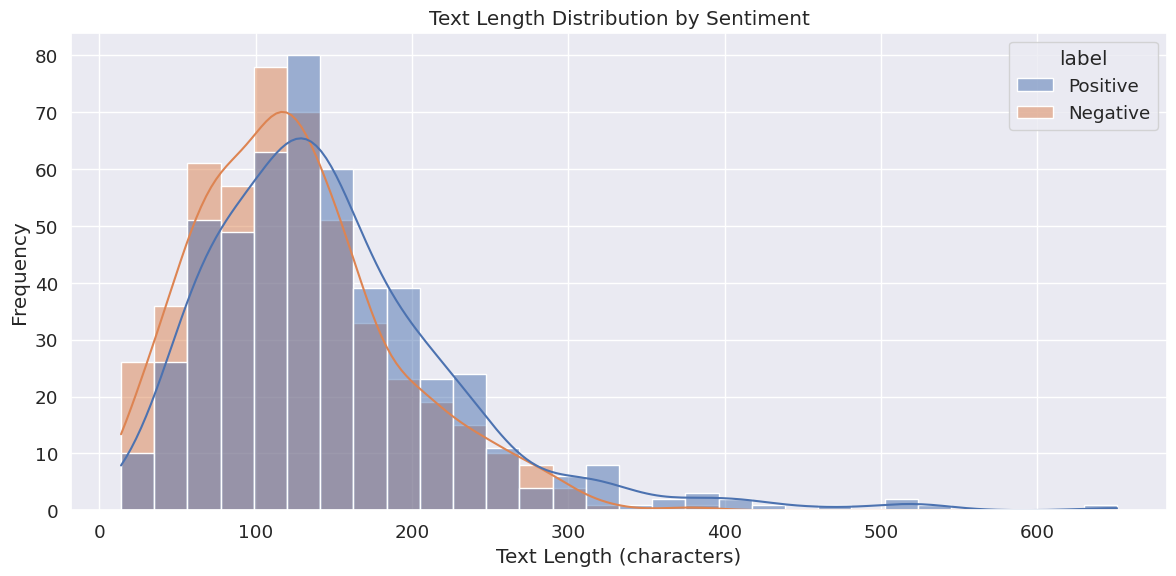

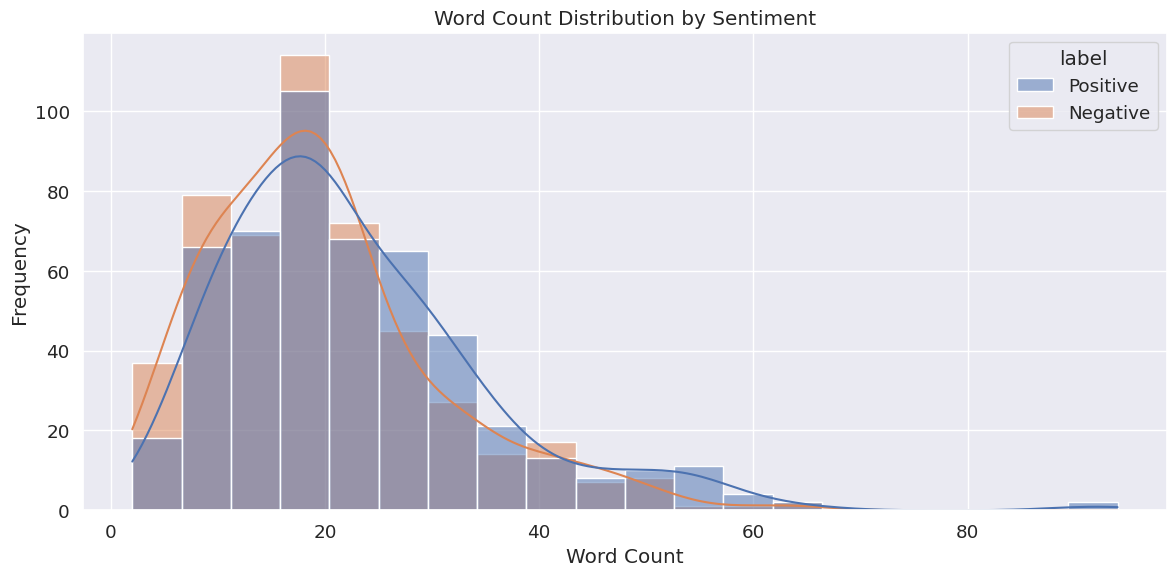

In [17]:
#  Text Length Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='text_length', hue='label', bins=30, kde=True)
plt.title('Text Length Distribution by Sentiment')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('text_length_distribution.png')

#  Word Count Distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='word_count', hue='label', bins=20, kde=True)
plt.title('Word Count Distribution by Sentiment')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('word_count_distribution.png')

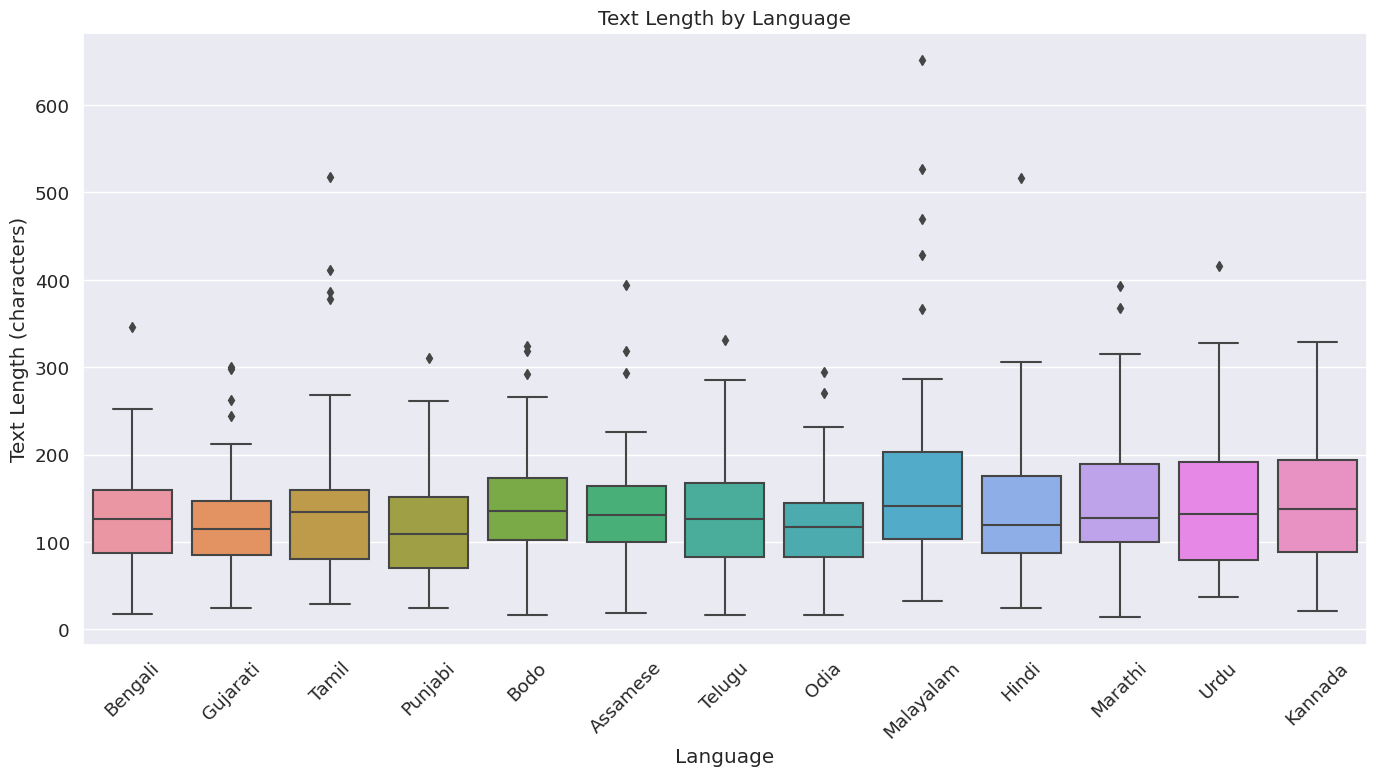

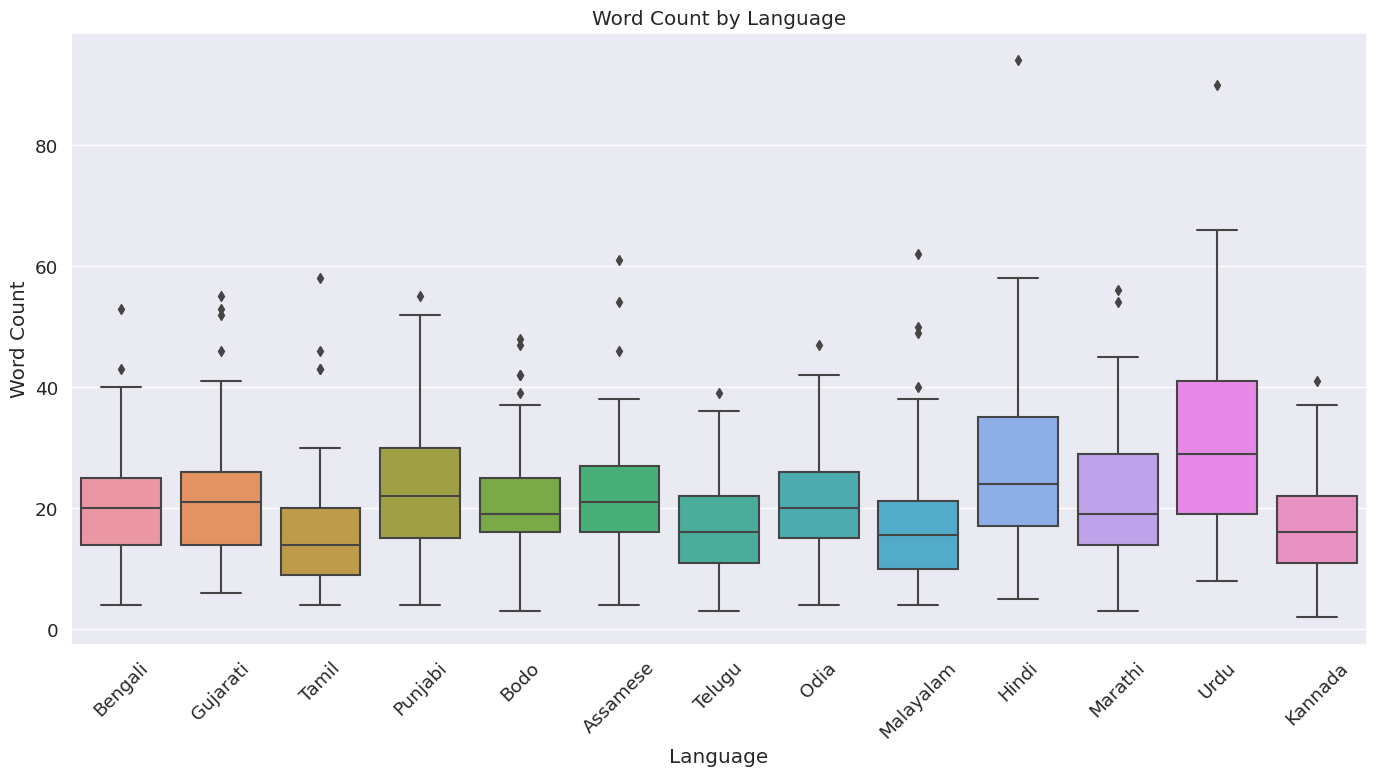

In [18]:
# Text Length by Language
plt.figure(figsize=(14, 8))
sns.boxplot(data=train_df, x='language_full', y='text_length')
plt.title('Text Length by Language')
plt.xlabel('Language')
plt.ylabel('Text Length (characters)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('text_length_by_language.png')

#  Word Count by Language
plt.figure(figsize=(14, 8))
sns.boxplot(data=train_df, x='language_full', y='word_count')
plt.title('Word Count by Language')
plt.xlabel('Language')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('word_count_by_language.png')

<Figure size 1400x800 with 0 Axes>

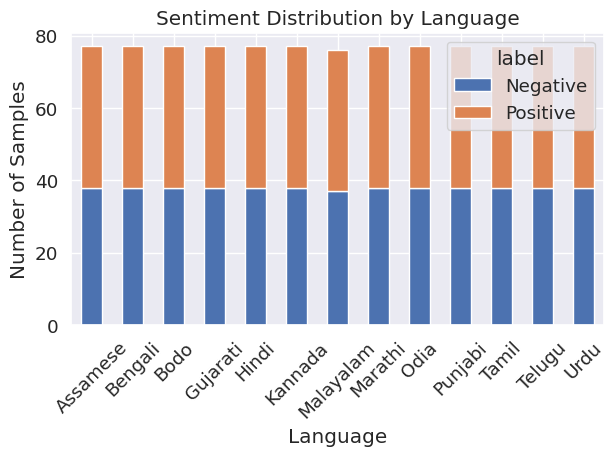

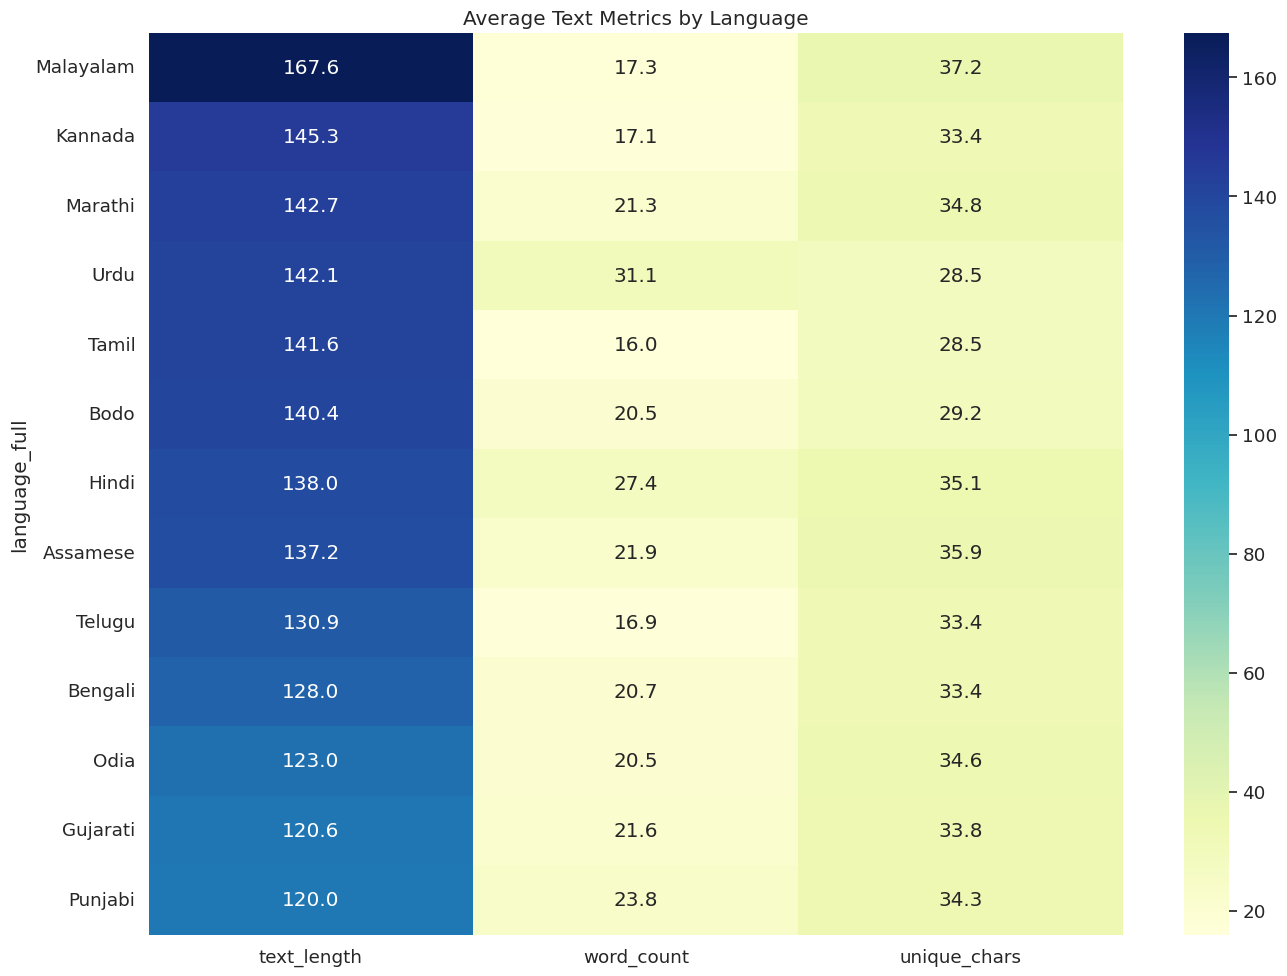

In [19]:
# Sentiment Distribution by Language
plt.figure(figsize=(14, 8))
sentiment_by_language.plot(kind='bar', stacked=True)
plt.title('Sentiment Distribution by Language')
plt.xlabel('Language')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('sentiment_distribution_by_language.png')

#  Heatmap of Text Length vs Word Count by Language
plt.figure(figsize=(14, 10))
lang_metrics = train_df.groupby('language_full').agg({
    'text_length': 'mean',
    'word_count': 'mean',
    'unique_chars': 'mean'
}).sort_values('text_length', ascending=False)

sns.heatmap(lang_metrics, annot=True, cmap='YlGnBu', fmt='.1f')
plt.title('Average Text Metrics by Language')
plt.tight_layout()
plt.savefig('language_metrics_heatmap.png')

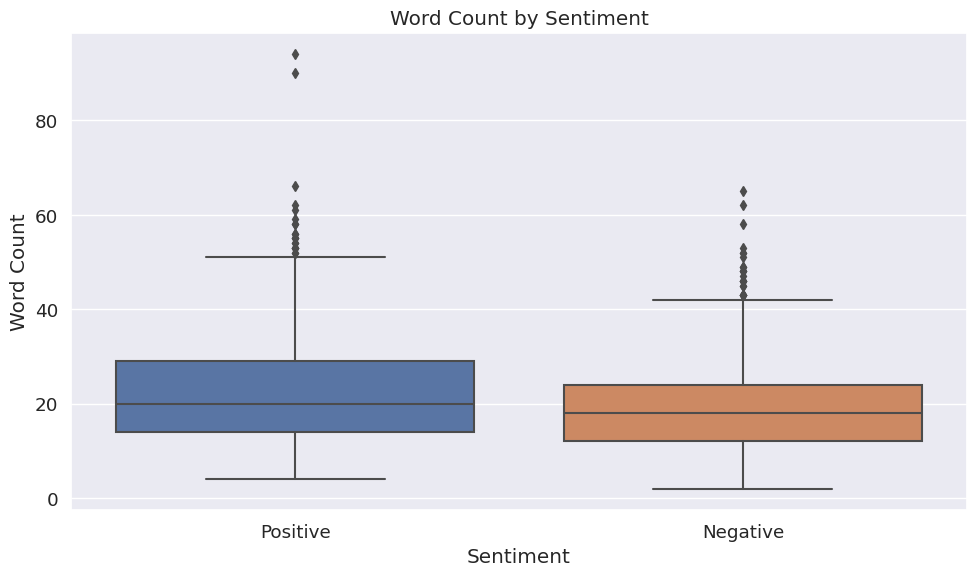

In [20]:
#  Word Count comparison between Positive and Negative sentiments
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='label', y='word_count')
plt.title('Word Count by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.tight_layout()
plt.savefig('word_count_by_sentiment.png')


<Figure size 1400x800 with 0 Axes>

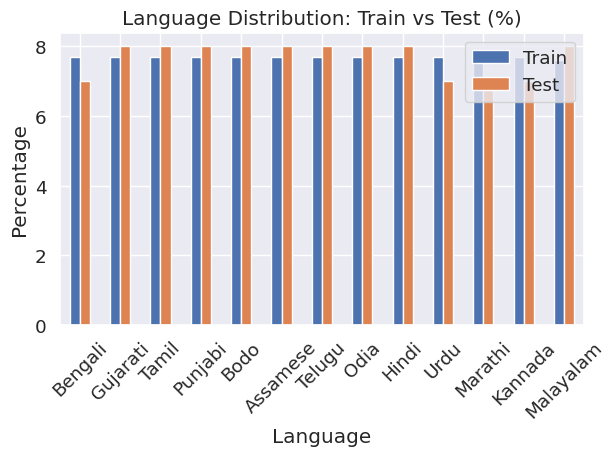

In [21]:
#  Train vs Test Language Distribution Comparison
plt.figure(figsize=(14, 8))
train_lang_pct = pd.Series(train_lang_pct, name='Train')
test_lang_pct = pd.Series(test_lang_pct, name='Test')
lang_pct_df = pd.DataFrame([train_lang_pct, test_lang_pct]).T
lang_pct_df.index = [language_map[code] for code in lang_pct_df.index]
lang_pct_df.plot(kind='bar')
plt.title('Language Distribution: Train vs Test (%)')
plt.xlabel('Language')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('language_distribution_comparison.png')

In [22]:
summary_stats = {
    "Total train samples": len(train_df),
    "Total test samples": len(test_df),
    "Languages covered": len(language_map),
    "Positive samples": sentiment_counts.get("Positive", 0),
    "Negative samples": sentiment_counts.get("Negative", 0),
    "Avg sentence length (chars)": train_df['text_length'].mean(),
    "Avg word count": train_df['word_count'].mean(),
    "Min sentence length": train_df['text_length'].min(),
    "Max sentence length": train_df['text_length'].max(),
    "Language with most samples": train_df['language_full'].value_counts().index[0],
    "Language with fewest samples": train_df['language_full'].value_counts().index[-1],
}

print("\nSummary Statistics:")
for key, value in summary_stats.items():
    print(f"{key}: {value}")


Summary Statistics:
Total train samples: 1000
Total test samples: 100
Languages covered: 13
Positive samples: 507
Negative samples: 493
Avg sentence length (chars): 136.704
Avg word count: 21.244
Min sentence length: 14
Max sentence length: 651
Language with most samples: Bengali
Language with fewest samples: Malayalam


In [23]:
from datetime import datetime
from unsloth import FastLanguageModel
import torch
import pandas as pd
import transformers
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import prepare_model_for_kbit_training, LoraConfig, PeftModel, get_peft_model
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

data_path = "/kaggle/input/multi-lingual-sentiment-analysis/multi-lingual-sentiment-analysis/train.csv"
eval_path = "/kaggle/input/multi-lingual-sentiment-analysis/multi-lingual-sentiment-analysis/test.csv"
base_model = "/kaggle/input/llama-3.1/transformers/8b-instruct/2"

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [24]:



sequence_length = 4096 
dtype = None 
load_in_4bit = True 
language_map = {
    "as": "Assamese",
    "bd": "Bodo",
    "bn": "Bengali",
    "gu": "Gujarati",
    "hi": "Hindi",
    "kn": "Kannada",
    "ml": "Malayalam",
    "mr": "Marathi",
    "or": "Odia",
    "pa": "Punjabi",
    "ta": "Tamil",
    "te": "Telugu",
    "ur": "Urdu"
}

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = base_model,
    max_seq_length = sequence_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)












==((====))==  Unsloth 2025.3.19: Fast Llama patching. Transformers: 4.50.3.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

/kaggle/input/llama-3.1/transformers/8b-instruct/2 does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.


In [25]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, 
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, 
    bias = "none",    
    use_gradient_checkpointing = "unsloth", 
    random_state = 3407,
    use_rslora = False,  
    loftq_config = None,
)


Unsloth 2025.3.19 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [26]:
instruction_template = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.
### Instruction:
Predict the sentiment of input as 1 (positive) or 0 (negative), output 0 or 1. This sentence comes from the {} language.
### Input:
{}
### Response:
{}"""

In [27]:
EOS_TOKEN = tokenizer.eos_token
def process_examples(examples):
    texts = []
    new_labels = []
    sentences = examples['sentence']
    langs = examples['language']
    labels = examples['label']
    for sent, lang, lab in zip(sentences, langs, labels):
        new_lab = 1 if lab == 'Positive' else 0
        text = instruction_template.format(language_map[lang], sent, new_lab) + EOS_TOKEN
        texts.append(text)
        new_labels.append(new_lab)
    return { "text" : texts, "label": new_labels}

dataset = load_dataset("csv", data_files = [data_path])["train"]
dataset = dataset.map(process_examples, batched = True,)
split_dataset = dataset.train_test_split(test_size = 0.2, seed = 62)
train_dataset, valid_dataset = split_dataset['train'], split_dataset['test']

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [28]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = sequence_length,
    dataset_num_proc = 2,
    packing = False,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 8,
        warmup_steps = 5,
        num_train_epochs = 5, 
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 10,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "checkpoints",
        report_to = "none",
    ),
)

trainer_stats = trainer.train()


Unsloth: Tokenizing ["text"] (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 800 | Num Epochs = 5 | Total steps = 125
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 8 x 1) = 32
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
10,1.320400
20,0.746900
30,0.618500
40,0.625300
50,0.612800
60,0.563100
70,0.512000
80,0.488400
90,0.465100
100,0.465800


In [29]:
FastLanguageModel.for_inference(model)
def predict_sentiment(examples):
    results = []
    sentences = examples['sentence']
    langs = examples['language']
    inputs = tokenizer(
        [
            instruction_template.format(language_map[langs], sentences, '')
        ], return_tensors = "pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
    result = int(tokenizer.batch_decode(outputs)[0].split('Response')[-1].split('\n')[1][0])
    return {'result': result}

In [30]:
train_dataset = train_dataset.map(predict_sentiment)
valid_dataset = valid_dataset.map(predict_sentiment)

def compute_metrics(actual, predicted):
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            if actual[i] == 1: tp += 1
            else: tn += 1
        else:
            if actual[i] == 1: fn += 1
            else: fp += 1
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    accuracy = (tp+tn) / (tp+tn+fp+fn)
    f1_score = (2 * precision * recall) / (precision+recall)
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}')
    print(f'F1 Score: {f1_score}')


Parameter 'function'=<function predict_sentiment at 0x7a69b8fa9bd0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [31]:
print('Train Metrics')
compute_metrics(train_dataset[:]['label'], train_dataset[:]['result'])
print('Validation Metrics')
compute_metrics(valid_dataset[:]['label'], valid_dataset[:]['result'])

model.save_pretrained("sentiment_model") 
tokenizer.save_pretrained("sentiment_model")


Train Metrics
Accuracy: 0.97375, Precision: 0.973621103117506, Recall: 0.9759615384615384
F1 Score: 0.9747899159663866
Validation Metrics
Accuracy: 0.965, Precision: 0.9772727272727273, Recall: 0.945054945054945
F1 Score: 0.9608938547486033


('sentiment_model/tokenizer_config.json',
 'sentiment_model/special_tokens_map.json',
 'sentiment_model/tokenizer.json')

In [32]:

test_dataset = load_dataset("csv", data_files = [eval_path])["train"]
test_dataset = test_dataset.map(predict_sentiment)

predictions = test_dataset[:]['result']
predictions = ['Positive' if predictions[i] == 1 else 'Negative' for i in range(len(predictions))]

submission = pd.DataFrame({'ID': list(range(1,len(predictions)+1)), 'label': predictions})
submission.to_csv('submission.csv', index=False)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]